In [2]:
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd

In [3]:
path = '/content/shopping_00001024.wav'
audio, sr = librosa.load(path, sr=22050)
ipd.Audio(audio, rate=sr)

(94303,)


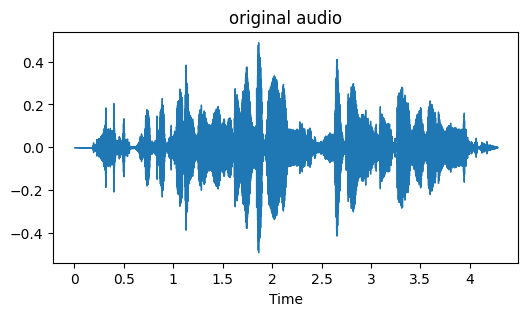

In [ ]:
plt.figure(figsize=(6, 3))
librosa.display.waveshow(y=audio, sr=sr)
plt.title('original audio')
print(audio.shape)

# SpecAugmet 이전 Data Augmentation 기법

### noise injection

np.random.uniform(low, high, size)와 np.random.rand()의 차이 : <br>
똑같이 uniform distribution(모든 값이 나올 확률이 서로 같은, 즉, 1/n인)에서 값을 뽑는데 uniform에선 값을 추출할 범위를 정할 수 있고, rand는 [0,1)로 고정되어있음.

uniform, normal 사용

In [ ]:
noise_amp = 0.035 * np.random.uniform() * np.amax(audio) #amax는 행렬 내 최댓값을 반환한다. uniform은 0~1의 균등함수이기 때문에 amax를 곱해주면 scaling의 역할을 한다.
audio += noise_amp * np.random.normal(size = audio.shape[0])

In [ ]:
ipd.Audio(audio, rate=rate)

Text(0.5, 1.0, 'noise audio')

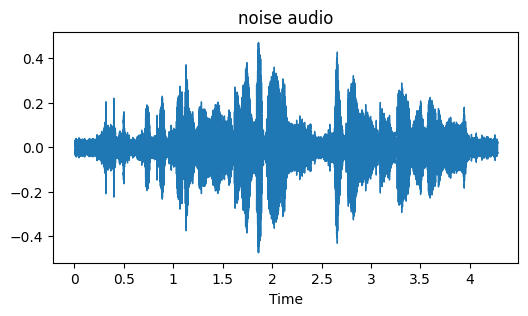

In [ ]:
plt.figure(figsize=(6, 3))
librosa.display.waveshow(y=audio, sr=sr)
plt.title('noise audio')

rand 사용

In [ ]:
noise = np.random.rand(len(audio)) / 10
print('noise info : ', noise.max(), noise.min(), noise[:10])
audio += noise
ipd.Audio(audio, rate=sr)

noise info :  0.09999924942730923 4.323274791939724e-07 [0.05420091 0.08467102 0.03440534 0.00128616 0.01759846 0.03261912
 0.06859826 0.02315582 0.01131646 0.04429472]


Text(0.5, 1.0, 'noise audio')

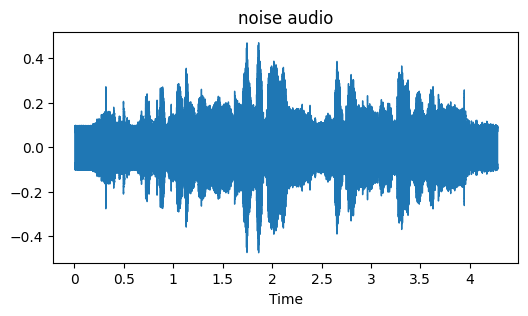

In [ ]:
plt.figure(figsize=(6, 3))
librosa.display.waveshow(y=audio, sr=rate)
plt.title('noise audio')

### Time Shift

In [ ]:
def left_shift(audio, time):
  audio = audio[int(sr*time):]
  return audio

# 오디오를 자르지 않게 조치
# 랜덤하게 왼쪽으로 밀건데 밀 범위는 맨앞 공백보다 작은 값으로
bl = audio < 0.01
index = np.where(bl==False)[0][0]
empty = (index+1)/sr

shift_time = np.random.uniform(0, empty, size=1)
print('shift time : ', shift_time)
shifted_audio = left_shift(audio, shift_time)

shift time :  [0.15067183]


Text(0.5, 1.0, 'noise audio')

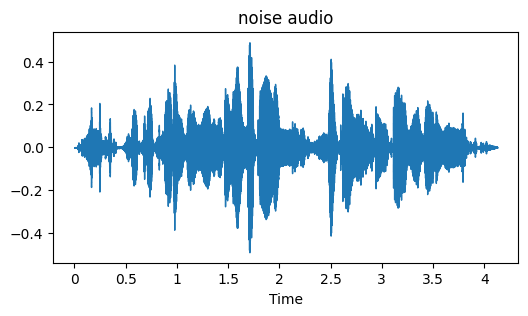

In [ ]:
plt.figure(figsize=(6, 3))
librosa.display.waveshow(y=shifted_audio, sr=sr)
plt.title('noise audio')

In [ ]:
def left_shift(audio, time):
  audio = audio[int(sr*time):]
  return audio

# 오디오를 잘리든 말든 무지성 밀기
shift_time = np.random.uniform(0, len(audio)/sr, size=1)
print('shift time : ', shift_time)
shifted_audio = left_shift(audio, shift_time)

shift time :  [1.7680163]


Text(0.5, 1.0, 'noise audio')

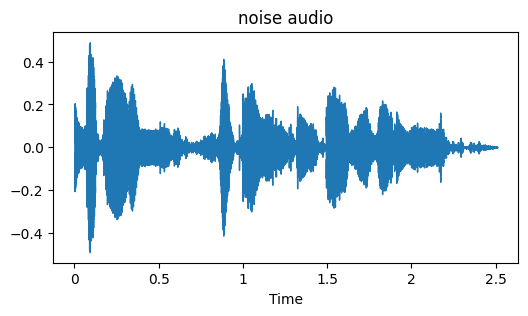

In [ ]:
plt.figure(figsize=(6, 3))
librosa.display.waveshow(y=shifted_audio, sr=sr)
plt.title('noise audio')

In [ ]:
def right_shift(audio, time):
  pad = np.zeros(int(sr*time))
  audio = np.concatenate((pad, audio), axis=None)
  return audio

shift_time = np.random.uniform(0, len(audio)/sr, size=1)
print('shift time : ', shift_time)
shifted_audio = right_shift(audio, shift_time)

shift time :  [0.81273967]


Text(0.5, 1.0, 'noise audio')

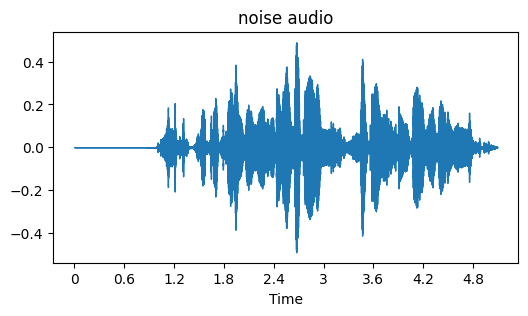

In [ ]:
plt.figure(figsize=(6, 3))
librosa.display.waveshow(y=shifted_audio, sr=sr)
plt.title('noise audio')

### Pitch Change

In [ ]:
def pitch_change(audio, sampling_rate, n_steps): # n_steps는 C~B까지의 12음계 기준 한 키를 의미한다. 예를 들어 n_steps = 2이면 두 키 업을 의미하고, n_steps = -4라고 하면 네 키 다운을 의미한다.
  if n_steps == 0:
    n_steps = 1
  return librosa.effects.pitch_shift(y = audio, sr = sampling_rate, n_steps = n_steps)

In [ ]:
n_steps = 3
changed_pitch = pitch_change(audio, sr, n_steps)
ipd.Audio(changed_pitch, rate=sr)

Text(0.5, 1.0, 'pitch changed audio')

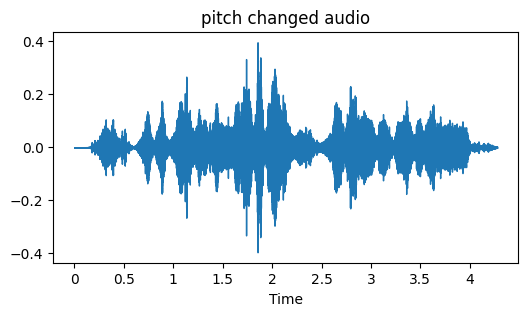

In [ ]:
plt.figure(figsize=(6, 3))
librosa.display.waveshow(y=changed_pitch, sr=sr)
plt.title('pitch changed audio')

### Speed Change

In [ ]:
def speed_change(audio, rate):
  #기존의 신호 길이 n이 round(n/rate)이 된다. 즉, rate이 1보다 낮다면 음성 신호를 늘이는 것이다.
  return librosa.effects.time_stretch(y = audio, rate = rate)

In [ ]:
rate = np.random.uniform(0.5, 3, 1)[0]
changed_speed = speed_change(audio, rate)
ipd.Audio(changed_speed, rate=sr)

Text(0.5, 1.0, 'speed changed audio')

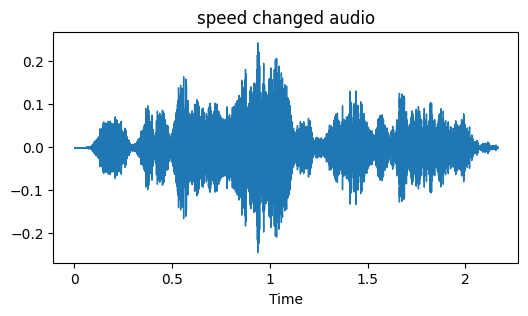

In [ ]:
plt.figure(figsize=(6, 3))
librosa.display.waveshow(y=changed_speed, sr=sr)
plt.title('speed changed audio')

# SpecAugment

In [4]:
# 2가지 방법
# (1)
#S_512 = np.abs(librosa.stft(audio, n_fft=512))
#mel_spec = librosa.feature.melspectrogram(S=S_512, n_mels=128)

#(2)
mel_spec = librosa.feature.melspectrogram(y=audio, n_fft=512, n_mels=128)

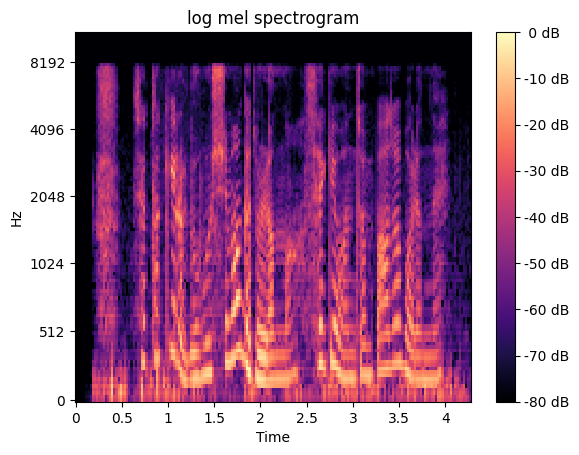

In [ ]:
librosa.display.specshow(librosa.power_to_db(mel_spec, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%2.0f dB')
plt.title('log mel spectrogram')
plt.show()

In [ ]:
mel_spec.shape

(128, 185)

## 직접 구현

### Time Warping

행은 16개마다 한 포인트, 열은 37개마다 한 포인트<br>
=> 8*5 = 40개의 포인트<br>
https://paeton.tistory.com/entry/%EC%9D%B4%EB%AF%B8%EC%A7%80-%EC%9B%8C%ED%95%91-image-Warping

In [12]:
def time_warping(mel_spec):
  result = np.copy(mel_spec)
  dxs, dys = [], []
  for num in range(40):
    dx = int(np.random.uniform(-1*num*16, num*16))
    dy = int(np.random.uniform(-1*num*37, num*37))
    dxs.append(dx)
    dys.append(dy)

  for box in range(40):
    dx = dxs[box]
    dy = dys[box]
    for i in range(16):
      for j in range(37):
        x = (box//5) * 16 + i
        y = (box%5) * 37 + j
        if 0 <= x+dx <= mel_spec.shape[0]-1 and 0 <= y+dy <= mel_spec.shape[1]-1:
          result[x+dx][y+dy] = mel_spec[x][y]

  return result

In [13]:
result = time_warping(mel_spec)

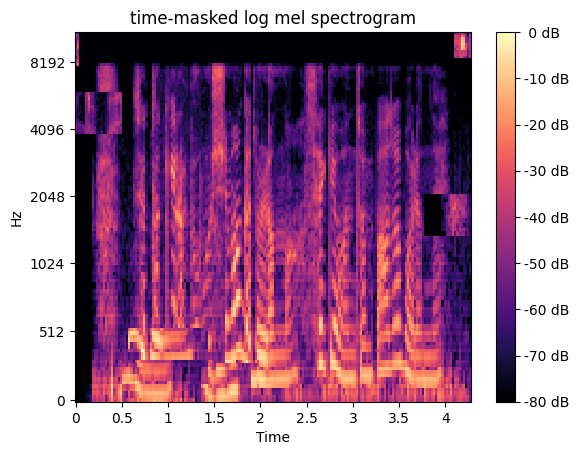

In [14]:
librosa.display.specshow(librosa.power_to_db(result, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%2.0f dB')
plt.title('time-masked log mel spectrogram')
plt.show()

### Time Masking

In [ ]:
def time_masking(mel_spec, T:int, p:float=1.0):
  '''
  Args:
    S : log mel spectrogram
    T : masking할 timestep(time interval)의 최대 개수 => T < mel_spec.shape[1] (열의 크기)
    tau : log mel spectrogram의 총 timestep 개수 => tau == mel_sepc.shape[0] (행의 크기)
    p : upper bound를 결정하는 portion => 0 <= p <= 1
    t : masking 시작 지점, [0, T]의 uniform distribution에서 랜덤하게 선택
        waveform의 길이 / mel_spec.shape[1] -> 한 개의 frame이 나타내는 시간 == timestep == time interval
        몇 초부터 masking이 시작되는지 알고 싶으면 t * timestep하면 됨.
    t0 : masking 길이, [0, tau-t]에서 랜덤하게 선택, 그러나 p*tau보다 크면 p*tau를 선택
    '''
  # T도 랜덤하게 뽑으면
  # T = int(np.random.uniform(0, tau))
  # p도 랜덤하게 뽑으면
  # p = np.random.uniform()

  # mel_spec이 바뀌지 않게 하려고 복사
  S = np.copy(mel_spec)
  tau = S.shape[1]
  t = int(np.random.uniform(0, T))
  t0 = int(min(np.random.uniform(0, tau-t), p*tau))

  print('시작 timestep : ', t)
  print('mask 길이 : ', t0)
  S[:, t:t+t0] = 0
  return S

시작 timestep :  12
mask 길이 :  67


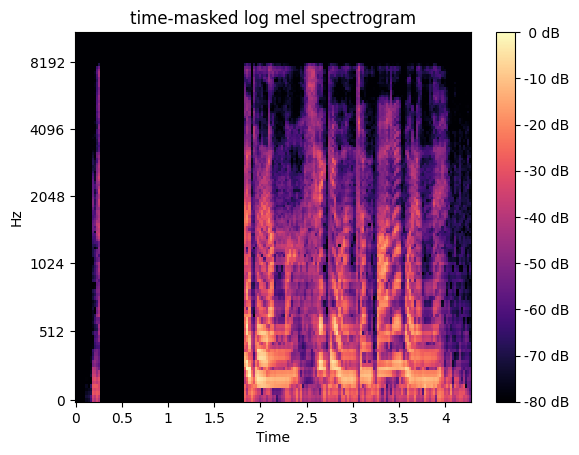

In [ ]:
masked_mel = time_masking(mel_spec, 64, p=0.4)
librosa.display.specshow(librosa.power_to_db(masked_mel, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%2.0f dB')
plt.title('time-masked log mel spectrogram')
plt.show()

### Frequency Masking

In [ ]:
def freq_masking(mel_spec, F:int):
  '''
  Args:
    S : log mel spectrogram
    F : masking할 mel band(time interval)의 최대 개수 => F < mel_spec.shape[1] (행의 크기)
    nu : log mel spectrogram의 총 mel band 개수 => nu == mel_sepc.shape[0] (열의 크기)
    f : masking 시작 지점, [0, F]의 uniform distribution에서 랜덤하게 선택
    f0 : masking 길이, [0, nu-f]
    '''
  # F도 랜덤하게 뽑으면
  # F = int(np.random.uniform(0, nu))
  S = np.copy(mel_spec)
  nu = S.shape[0]
  mask_length = S.shape[1]
  f = int(np.random.uniform(0, F))
  f0 = int(np.random.uniform(0, nu-f))
  mask = np.zeros(mask_length)

  print('시작 freq channel : ', f)
  print('mask 길이 : ', f0)
  S[f:f+f0, :] = 0
  return S

시작 freq channel :  48
mask 길이 :  37


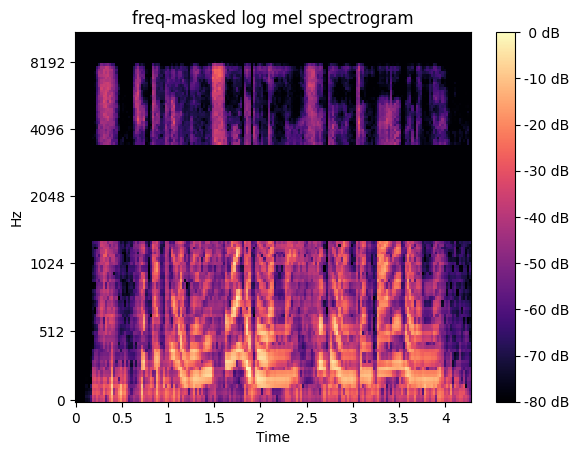

In [ ]:
freq_masked_mel = freq_masking(mel_spec, 50)
librosa.display.specshow(librosa.power_to_db(freq_masked_mel, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%2.0f dB')
plt.title('freq-masked log mel spectrogram')
plt.show()

## Pytorch

https://pytorch.org/audio/master/tutorials/audio_feature_augmentation_tutorial.html#specaugment

In [ ]:
import torch
import torchaudio
import torchaudio.transforms as T

### Time Masking, Frequency Masking

In [ ]:
torch_melspec = torch.from_numpy(mel_spec)
# 파라미터 랜덤 선택
time_mask_param = int(np.random.uniform(0, mel_spec.shape[0]))
freq_mask_param = int(np.random.uniform(0, mel_spec.shape[1]))
# masking class 만들기
time_masking = T.TimeMasking(time_mask_param)
freq_masking = T.FrequencyMasking(freq_mask_param)
# masking
time_masked = time_masking(torch_melspec)
freq_masked = freq_masking(torch_melspec)

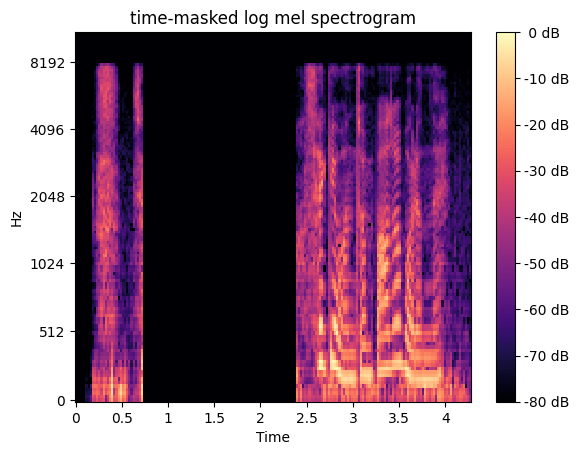

In [ ]:
librosa.display.specshow(librosa.power_to_db(time_masked, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%2.0f dB')
plt.title('time-masked log mel spectrogram')
plt.show()

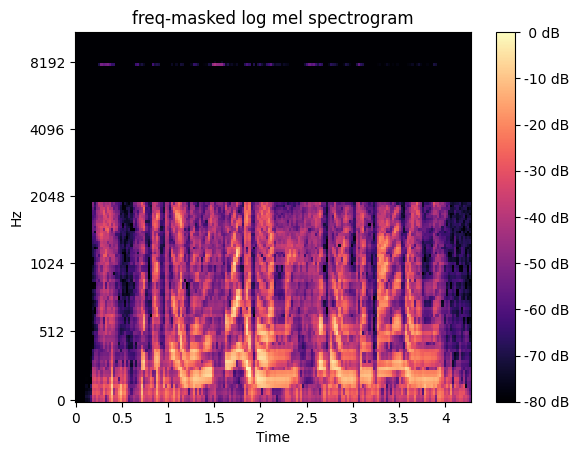

In [ ]:
librosa.display.specshow(librosa.power_to_db(freq_masked, ref=np.max), y_axis='mel', x_axis='time')
plt.colorbar(format='%2.0f dB')
plt.title('freq-masked log mel spectrogram')
plt.show()